## Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# from torchmetrics.detection import MeanAveragePrecision

# import pycocotools

In [2]:
# # imports from local lib files
# import utils
# import transforms
# import coco_eval
# from engine import train_one_epoch, evaluate

In [ ]:
# Imports for evaluation from local lib files
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

## File paths

In [2]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [3]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [4]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


In [13]:
trans_test_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [14]:
trans_test_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [17]:
train_ann['images'][0]

{'file_name': '5a2176e7-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2011-11-29 17:28:26',
 'location': 38,
 'seq_num_frames': 3,
 'seq_id': '6f011019-5567-11e8-a650-dca9047ef277',
 'id': '5a2176e7-23d2-11e8-a6a3-ec086b02610b'}

In [18]:
trans_val_ann['images'][1]

{'file_name': '592163c4-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 3,
 'date_captured': '2012-05-07 21:51:02',
 'location': 125,
 'seq_num_frames': 3,
 'seq_id': '6f16649c-5567-11e8-bc01-dca9047ef277',
 'id': '592163c4-23d2-11e8-a6a3-ec086b02610b'}

In [19]:
train_ann['images'][2]

{'file_name': '59af966d-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 3,
 'date_captured': '2011-12-15 09:50:03',
 'location': 43,
 'seq_num_frames': 3,
 'seq_id': '6f0be74a-5567-11e8-8662-dca9047ef277',
 'id': '59af966d-23d2-11e8-a6a3-ec086b02610b'}

In [20]:
cis_test_ann['images'][0]

{'file_name': '59b93afb-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2012-05-09 07:33:45',
 'location': 38,
 'seq_num_frames': 3,
 'seq_id': '6f04895c-5567-11e8-a3d6-dca9047ef277',
 'id': '59b93afb-23d2-11e8-a6a3-ec086b02610b'}

In [21]:
cis_test_ann['images'][1]

{'file_name': '59641f56-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2012-03-29 02:34:13',
 'location': 38,
 'seq_num_frames': 3,
 'seq_id': '6f0385b5-5567-11e8-a80b-dca9047ef277',
 'id': '59641f56-23d2-11e8-a6a3-ec086b02610b'}

## Horizontal flip debugging

{'file_name': '5a063197-23d2-11e8-a6a3-ec086b02610b.jpg', 'rights_holder': 'Erin Boydston', 'height': 1536, 'width': 2048, 'frame_num': 1, 'date_captured': '2012-01-04 16:47:00', 'location': 0, 'seq_num_frames': 1, 'seq_id': '700bdc38-5567-11e8-87bc-dca9047ef277', 'id': '5a063197-23d2-11e8-a6a3-ec086b02610b'}


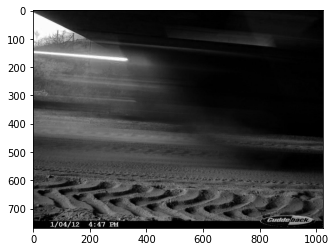

In [124]:
i = 3
print(trans_test_ann['images'][i])
img_path = os.path.join('eccv_18_all_images_sm', trans_test_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(), cmap='gray')

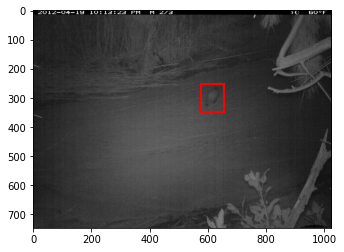

In [109]:
i = 0

boxes = [trans_test_ann['annotations'][j]['bbox'] for j in range(len(trans_test_ann['annotations'])) 
         if trans_test_ann['annotations'][j]['image_id']==trans_test_ann['images'][i]['id'] 
         and 'bbox' in trans_test_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_test_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(), cmap='gray')

scale_x = image.shape[2] / trans_test_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_test_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [ ]:
img_path

In [ ]:
image2 = Image.open(img_path).convert("RGB")

In [ ]:
image2

In [ ]:
image2.size

In [ ]:
conv = torchvision.transforms.ToTensor()

In [ ]:
width, height = image2.size[0], image2.size[1]

In [ ]:
print('width:', width)
print('height:', height)

In [ ]:
image_new = conv(image2)

In [ ]:
print('image_new.shape:', image_new.shape)

## Utils part

In [ ]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from local files (from github repo)

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [ ]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target

## Exemple of use

In [ ]:
# get the images bounding boxes *takes about 25sec*
train_valid_img,_ = get_img_with_bbox(train_ann_path)
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)

In [ ]:
training_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

# In paper : ' We use a batch size of 1'

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
    label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

In [ ]:
trans = data_transform['train']
img2, target2 = trans(image, target)

fig, ax = plt.subplots()
ax.imshow(img2, cmap="gray")

rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), 
                         target2['boxes'][0][2] - target2['boxes'][0][0], 
                         target2['boxes'][0][3] - target2['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

### Plots

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '25_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = train_logs + json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = cis_valid_logs + json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = trans_valid_logs + json.load(f)

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

In [ ]:
# To confirm that the data is loaded properly
len(train_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])

In [ ]:
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

In [ ]:
train_logs_0_9 = [train_logs[i]['loss_box_reg'] for i in range(0, 10)]

In [ ]:
train_logs_10_25 = [train_logs[i]['loss_box_reg']['global_avg'] for i in range(10, 25)]

In [ ]:
train_logs = train_logs_0_9 + train_logs_10_25

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

x = np.array([[[1,2,3],
               [3,4,5],
               [5,6,7]],
              [[5,6,7],
               [7,8,9],
               [9,0,1]]])

In [ ]:
i,j,k = x.shape

xx = x.reshape(i,j*k).T
xx

In [ ]:
y = np.array([[[8,7,6],
               [6,5,4],
               [4,3,2]],
              [[4,3,2],
               [2,1,0],
               [0,1,2]]])


yy = y.reshape(i,j*k).T

In [ ]:
cdist(xx,yy,'mahalanobis')

## Plots with data

## Logs utils

#### Train logs utils

In [5]:
import time

In [6]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values


# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst


# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

In [7]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [8]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [9]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [10]:
# Converts the valid logs from list of dictionnaries to string
# TODO: add if type == list to not do anything if its already a list
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [11]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [13]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [14]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

# CHECK DEVICE BEFORE TRAINING
# torch.cuda.get_device_name(0)

## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [12]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '50_rpn_roi_2' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

In [57]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '75_rpn_roi_1' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = train_logs + json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = cis_valid_logs + json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = trans_valid_logs + json.load(f)

In [13]:
# To confirm that the data is loaded properly
len(train_logs)

50

In [14]:
num_epochs = len(train_logs)

In [15]:
cis_valid_logs[0]

{'loss_classifier': 0.041888557374477386,
 'loss_box_reg': 0.07204102724790573,
 'loss_objectness': 0.010373682714998722,
 'loss_rpn_box_reg': 0.002855970524251461}

In [22]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_rpn_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_rpn_box_reg']
    results_trans_valid_loss.append(loss_interm)

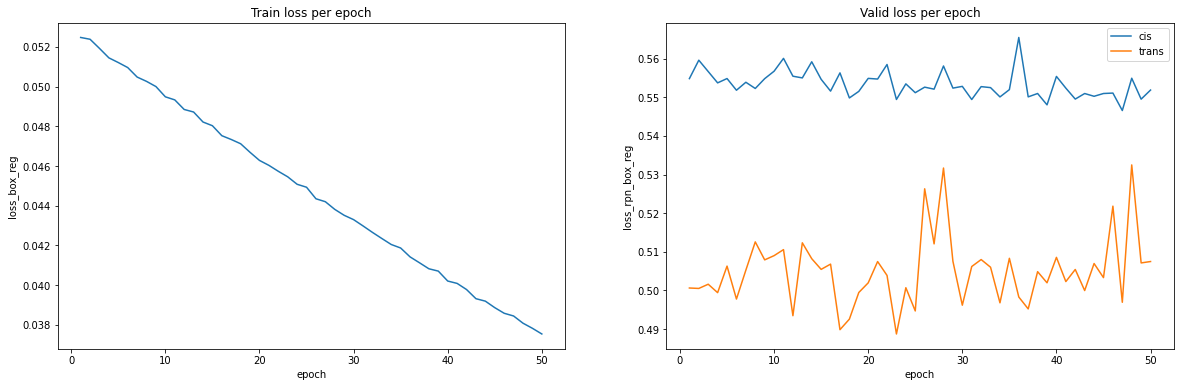

In [23]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_rpn_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

#### Save the figure to pdf format in the figures folder

In [ ]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

In [72]:
fig.savefig("figures/full_75_rpn_roi_1_figure.pdf")

## Table to show results (manually)

In [71]:
# RPN + ROI
cis_results = [0.863, 0.895, 0.897]
trans_results = [0.781, 0.794, 0.785]
delta_results = [cis_results[i]-trans_results[i] for i in range(len(cis_results))]

Text(0.5, 0, 'epoch')

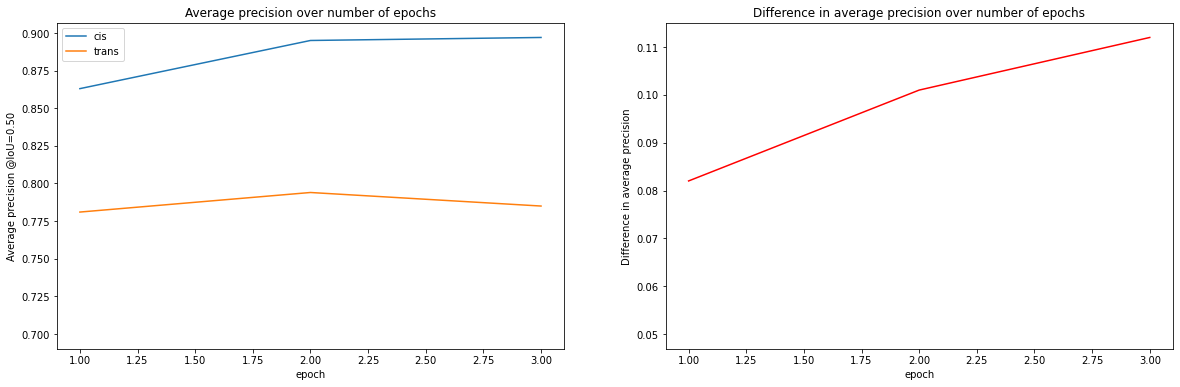

In [72]:
# RPN + ROI: Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, len(cis_results) + 1), cis_results, label='cis')
ax[0].plot(np.arange(1, len(trans_results) + 1), trans_results, label='trans')
ax[0].axhline(y=0.7, c="white")
ax[0].set_title('Average precision over number of epochs')
ax[0].set_ylabel('Average precision @IoU=0.50')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(np.arange(1, len(cis_results) + 1), delta_results,'r', label='train')
ax[1].axhline(y=0.05, c="white")
ax[1].set_title('Difference in average precision over number of epochs')
ax[1].set_ylabel('Difference in average precision')
ax[1].set_xlabel('epoch')

In [73]:
plt.bar

<function matplotlib.pyplot.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)>

<function matplotlib.pyplot.show(close=None, block=None)>

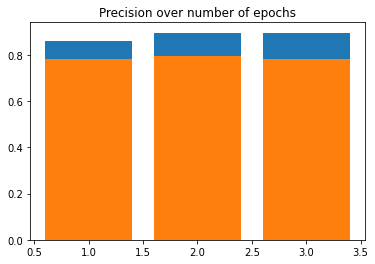

In [77]:
plt.bar(np.arange(1, 3 + 1), cis_results, label='xd')
plt.bar(np.arange(1, 3 + 1), trans_results)
plt.title('Precision over number of epochs')
plt.show

In [ ]:
# base vs roi vs roi+rpn
cis_results = [0.863, 0.895, 0.897]

# Training

In [63]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '25_base' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_base = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_base = json.load(f)

# Import trans valid logsw
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_base = json.load(f)

In [100]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '25_roi_4_vision_version_diff' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_roi = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_roi = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_roi = json.load(f)

In [101]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '25_rpn_roi_1' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_rpn_roi = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_rpn_roi = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_rpn_roi = json.load(f)

In [356]:
# base
results_train_loss_base = []

for i in range(num_epochs):
    results_train_loss_base.append(train_base[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss_base = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_base[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss_base.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss_base = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_base[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss_base.append(loss_interm)

In [357]:
# roi
results_train_loss_roi = []

for i in range(num_epochs):
    results_train_loss_roi.append(train_roi[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss_roi = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_roi[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss_roi.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss_roi = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_roi[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss_roi.append(loss_interm)

In [358]:
# rpn+roi
results_train_loss_rpn_roi = []

for i in range(num_epochs):
    results_train_loss_rpn_roi.append(train_rpn_roi[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss_rpn_roi = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_rpn_roi[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss_rpn_roi.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss_rpn_roi = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_rpn_roi[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss_rpn_roi.append(loss_interm)

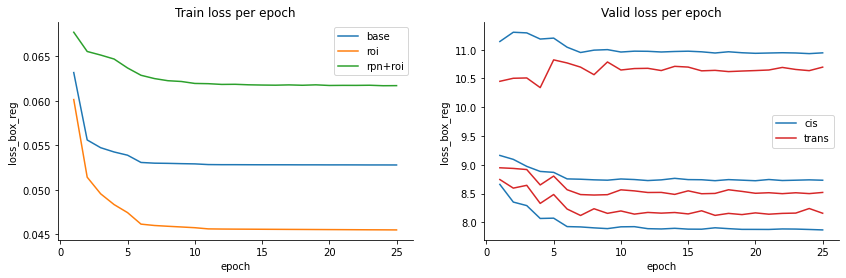

In [359]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss_base, label='base')
ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss_roi, label='roi')
ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss_rpn_roi, label='rpn+roi')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')
ax[0].legend()

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss_base, label='cis', color='tab:blue')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss_base, label='trans', color='tab:red')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss_roi, color='tab:blue')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss_roi, color='tab:red')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss_rpn_roi, color='tab:blue')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss_rpn_roi, color='tab:red')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

In [360]:
fig.savefig("figures/baseline_vs_roi_vs_rpn_roi_training.png", transparent=True)

In [350]:
# Cis valid loss to print
results_cis_valid_loss_base = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_base[(167 * i) + j]['loss_rpn_box_reg']
    results_cis_valid_loss_base.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss_base = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_base[(154 * i) + j]['loss_rpn_box_reg']
    results_trans_valid_loss_base.append(loss_interm)

In [351]:
# Cis valid loss to print
results_cis_valid_loss_roi = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_roi[(167 * i) + j]['loss_rpn_box_reg']
    results_cis_valid_loss_roi.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss_roi = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_roi[(154 * i) + j]['loss_rpn_box_reg']
    results_trans_valid_loss_roi.append(loss_interm)

In [352]:
# Cis valid loss to print
results_cis_valid_loss_rpn_roi = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_rpn_roi[(167 * i) + j]['loss_rpn_box_reg']
    results_cis_valid_loss_rpn_roi.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss_rpn_roi = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_rpn_roi[(154 * i) + j]['loss_rpn_box_reg']
    results_trans_valid_loss_rpn_roi.append(loss_interm)

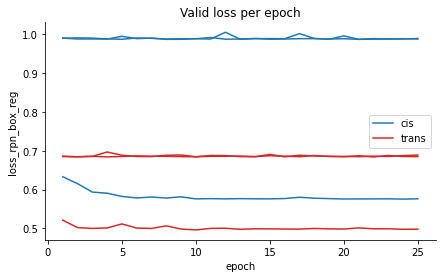

In [353]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

plt.title('Train loss per epoch')
ax.plot(np.arange(1, num_epochs + 1), results_cis_valid_loss_base, label='cis', color='tab:blue')
ax.plot(np.arange(1, num_epochs + 1), results_trans_valid_loss_base, label='trans', color='tab:red')
ax.plot(np.arange(1, num_epochs + 1), results_cis_valid_loss_roi, color='tab:blue')
ax.plot(np.arange(1, num_epochs + 1), results_trans_valid_loss_roi, color='tab:red')
ax.plot(np.arange(1, num_epochs + 1), results_cis_valid_loss_rpn_roi, color='tab:blue')
ax.plot(np.arange(1, num_epochs + 1), results_trans_valid_loss_rpn_roi, color='tab:red')
ax.set_title('Valid loss per epoch')
ax.set_ylabel('loss_rpn_box_reg')
ax.set_xlabel('epoch')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [354]:
fig.savefig("figures/baseline_vs_roi_vs_rpn_roi_training_rpn.png", transparent=True)

# Evaluations

### Different depths

<function matplotlib.pyplot.show(close=None, block=None)>

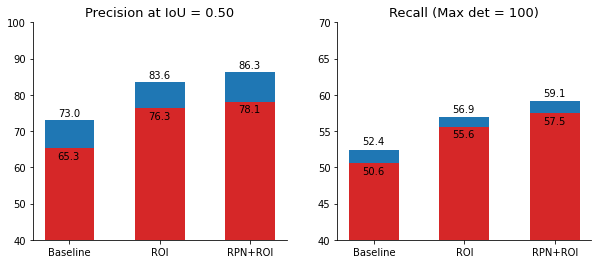

In [366]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Create bars
barWidth = 0.55
bars1 = [73.0, 65.3]
bars2 = [52.4, 50.6]

bars3 = [83.6, 76.3]
bars4 = [56.9, 55.6]

bars5 = [86.3, 78.1]
bars6 = [59.1, 57.5]

bars = bars1+bars3+bars5
bars_recall = bars2+bars4+bars6

# The X position of bars
r1 = [1, 1]
r2 = [2, 2]
r3 = [3, 3]
r4 = r1+r2+r3

# Text below each barplot with a rotation at 90°
ax[0].set_xticks([1, 2, 3], ['Baseline', 'ROI', 'RPN+ROI'])
ax[1].set_xticks([1, 2, 3], ['Baseline', 'ROI', 'RPN+ROI'])

# Create barplot 1
ax[0].bar(r1, bars1, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].bar(r2, bars3, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].bar(r3, bars5, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].axis(ymin=40, ymax=100)
ax[0].set_title('Precision at IoU = 0.50', fontsize=13)
for i, v in enumerate(r4):
    if i%2 ==0:
        ax[0].text(v-0.13, bars[i] + 1, str(bars[i]), color='black')
    else:
        ax[0].text(v-0.13, bars[i] - 3, str(bars[i]), color='black')


# Create barplot 2
ax[1].bar(r1, bars2, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].bar(r2, bars4, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].bar(r3, bars6, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].axhline(100, color='white')
ax[1].axis(ymin=40, ymax=70)
ax[1].set_title('Recall (Max det = 100)', fontsize=13)
for i, v in enumerate(r4):
    if i%2 ==0:
        ax[1].text(v-0.13, bars_recall[i] + 0.75, str(bars_recall[i]), color='black')
    else:
        ax[1].text(v-0.13, bars_recall[i] - 1.5, str(bars_recall[i]), color='black')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.savefig("figures/baseline_vs_roi_vs_rpn_roi_precision_recall.png", transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

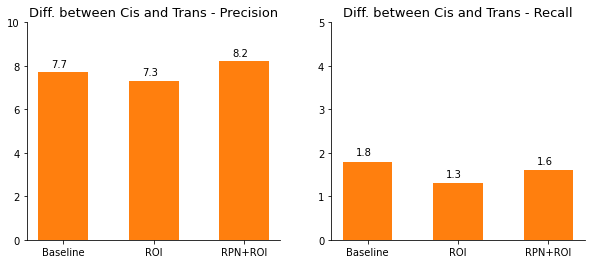

In [367]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Create bars
barWidth = 0.55
diff_bars1 = [round(bars1[0]-bars1[1], 3)]
diff_bars2 = [round(bars2[0]-bars2[1], 3)]

diff_bars3 = [round(bars3[0]-bars3[1], 3)]
diff_bars4 = [round(bars4[0]-bars4[1], 3)]

diff_bars5 = [round(bars5[0]-bars5[1], 3)]
diff_bars6 = [round(bars6[0]-bars6[1], 3)]

diff_bars = diff_bars1+diff_bars3+diff_bars5
diff_bars_recall = diff_bars2+diff_bars4+diff_bars6

# The X position of bars
r1 = [1]
r2 = [2]
r3 = [3]
r4 = r1+r2+r3

# Text below each barplot with a rotation at 90°
ax[0].set_xticks([1, 2, 3], ['Baseline', 'ROI', 'RPN+ROI'])
ax[1].set_xticks([1, 2, 3], ['Baseline', 'ROI', 'RPN+ROI'])

# Create barplot 1
ax[0].bar(r1, diff_bars1, width = barWidth, color = ('tab:orange'))
ax[0].bar(r2, diff_bars3, width = barWidth, color = ('tab:orange'))
ax[0].bar(r3, diff_bars5, width = barWidth, color = ('tab:orange'))
ax[0].axis(ymin=0, ymax=10)
ax[0].set_title('Diff. between Cis and Trans - Precision', fontsize=13)
for i, v in enumerate(r4):
    ax[0].text(v-0.13, diff_bars[i] + 0.25, str(diff_bars[i]), color='black')


# Create barplot 2
ax[1].bar(r1, diff_bars2, width = barWidth, color = ('tab:orange'))
ax[1].bar(r2, diff_bars4, width = barWidth, color = ('tab:orange'))
ax[1].bar(r3, diff_bars6, width = barWidth, color = ('tab:orange'))
ax[1].axhline(100, color='white')
ax[1].axis(ymin=0, ymax=5)
ax[1].set_title('Diff. between Cis and Trans - Recall', fontsize=13)
for i, v in enumerate(r4):
    ax[1].text(v-0.13, diff_bars_recall[i] + 0.15, str(diff_bars_recall[i]), color='black')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.savefig("figures/baseline_vs_roi_vs_rpn_roi_diff.png", transparent=True)

plt.show

### Number of epochs

<function matplotlib.pyplot.show(close=None, block=None)>

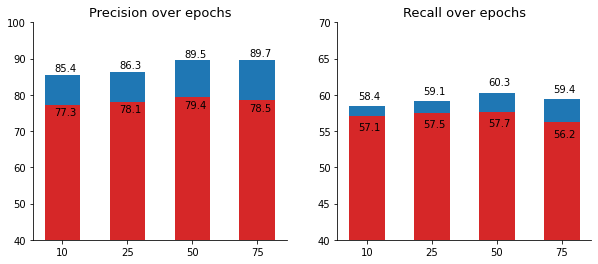

In [370]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Create bars
barWidth = 0.55

bars00 = [85.4, 77.3]
bars0 = [58.4, 57.1]

bars1 = [86.3, 78.1]
bars2 = [59.1, 57.5]

bars3 = [89.5, 79.4]
bars4 = [60.3, 57.7]

bars5 = [89.7, 78.5]
bars6 = [59.4, 56.2]

bars = bars00+bars1+bars3+bars5
bars_recall = bars0+bars2+bars4+bars6

# The X position of bars
r0 = [1, 1]
r1 = [2, 2]
r2 = [3, 3]
r3 = [4, 4]
r4 = r0+r1+r2+r3

# Text below each barplot
ax[0].set_xticks([1, 2, 3, 4], ['10', '25', '50', '75'])
ax[1].set_xticks([1, 2, 3, 4], ['10', '25', '50', '75'])

# Create barplot 1
ax[0].bar(r0, bars00, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].bar(r1, bars1, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].bar(r2, bars3, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].bar(r3, bars5, width = barWidth, color = ('tab:blue','tab:red'))
ax[0].axis(ymin=40, ymax=100)
ax[0].set_title('Precision over epochs', fontsize=13)
for i, v in enumerate(r4):
    if i%2 ==0:
        ax[0].text(v-0.13, bars[i] + 1, str(bars[i]), color='black')
    else:
        ax[0].text(v-0.13, bars[i] - 3, str(bars[i]), color='black')


# Create barplot 2
ax[1].bar(r0, bars0, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].bar(r1, bars2, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].bar(r2, bars4, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].bar(r3, bars6, width = barWidth, color = ('tab:blue','tab:red'))
ax[1].axhline(100, color='white')
ax[1].axis(ymin=40, ymax=70)
ax[1].set_title('Recall over epochs', fontsize=13)
for i, v in enumerate(r4):
    if i%2 ==0:
        ax[1].text(v-0.13, bars_recall[i] + 1, str(bars_recall[i]), color='black')
    else:
        ax[1].text(v-0.13, bars_recall[i] - 2, str(bars_recall[i]), color='black')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.savefig("figures/rpn_roi_epochs_precision_recall.png", transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

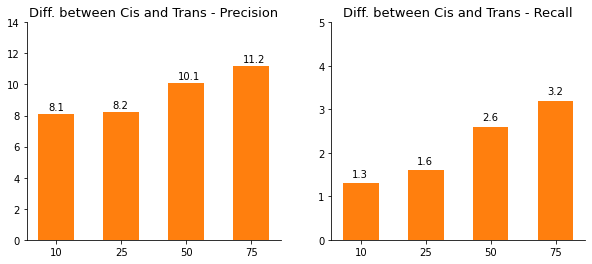

In [371]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Create bars
barWidth = 0.55

diff_bars00 = [round(bars00[0]-bars00[1], 3)]
diff_bars0 = [round(bars0[0]-bars0[1], 3)]

diff_bars1 = [round(bars1[0]-bars1[1], 3)]
diff_bars2 = [round(bars2[0]-bars2[1], 3)]

diff_bars3 = [round(bars3[0]-bars3[1], 3)]
diff_bars4 = [round(bars4[0]-bars4[1], 3)]

diff_bars5 = [round(bars5[0]-bars5[1], 3)]
diff_bars6 = [round(bars6[0]-bars6[1], 3)]

diff_bars = diff_bars00+diff_bars1+diff_bars3+diff_bars5
diff_bars_recall = diff_bars0+diff_bars2+diff_bars4+diff_bars6

# The X position of bars
r0 = [1]
r1 = [2]
r2 = [3]
r3 = [4]
r4 = r0+r1+r2+r3

# Text below each barplot with a rotation at 90°
ax[0].set_xticks([1, 2, 3, 4], ['10', '25', '50', '75'])
ax[1].set_xticks([1, 2, 3, 4], ['10', '25', '50', '75'])

# Create barplot 1
ax[0].bar(r0, diff_bars00, width = barWidth, color = ('tab:orange'))
ax[0].bar(r1, diff_bars1, width = barWidth, color = ('tab:orange'))
ax[0].bar(r2, diff_bars3, width = barWidth, color = ('tab:orange'))
ax[0].bar(r3, diff_bars5, width = barWidth, color = ('tab:orange'))
ax[0].axis(ymin=0, ymax=14)
ax[0].set_title('Diff. between Cis and Trans - Precision', fontsize=13)
for i, v in enumerate(r4):
    ax[0].text(v-0.13, diff_bars[i] + 0.25, str(diff_bars[i]), color='black')


# Create barplot 2
ax[1].bar(r0, diff_bars0, width = barWidth, color = ('tab:orange'))
ax[1].bar(r1, diff_bars2, width = barWidth, color = ('tab:orange'))
ax[1].bar(r2, diff_bars4, width = barWidth, color = ('tab:orange'))
ax[1].bar(r3, diff_bars6, width = barWidth, color = ('tab:orange'))
ax[1].axis(ymin=0, ymax=5)
ax[1].set_title('Diff. between Cis and Trans - Recall', fontsize=13)
for i, v in enumerate(r4):
    ax[1].text(v-0.13, diff_bars_recall[i] + 0.15, str(diff_bars_recall[i]), color='black')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.savefig("figures/rpn_roi_epochs_precision_diff.png", transparent=True)

plt.show